In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import pickle
import importlib
from joblib import dump, load
import seaborn as sns
from scipy.stats import linregress
from scipy.signal import hilbert, find_peaks

In [24]:
# with open('modalities_dataframe.pkl', 'rb') as f:
with open('fsr_records/aligned_data_v0.pkl', 'rb') as f:
    loaded_data = pickle.load(f)


In [49]:
def zero_mean_sig(sig, seconds=40):
    #set every 1 sec interval mean to zero
    prev=0
    for i in np.int16(np.linspace(0,len(sig),40)):
        sig[prev:i]=sig[prev:i]-np.mean(sig[prev:i])
        prev=i
    return sig

def multiplot(data, ind):
    """
    plots z-scored values of all recorded channels in 1 plot with transparency

    Args:
        data (_type_): _description_
        ind (_type_): _description_
    """    
    
    for key in ['X List','Y List', 'Z List']:
        #Align x values
        x = np.linspace(0, 50, len(data[key][ind]))
        #convert from string to float
        sig = np.float32(data[key][ind])
        zsig = (sig-np.nanmean(sig))/np.nanstd(sig)
        #plot with label and transparency
        plt.plot(x, zsig, label=key, alpha = 0.5)

    plt.legend()
    plt.show()

def plot_data_in_range(df, modality = 'grip', sensorType = 'accel', axis='x', gt_min=0, gt_max=20):
    """
    Plots all the `axis` lists from rows where the ground truth value is within [gt_min, gt_max].

    Parameters:
    df (pd.DataFrame): DataFrame containing 'x', 'y', 'z' list columns and a 'ground_truth' column.
    axis (str): Axis to plot ('x', 'y', or 'z').
    gt_min (float): Minimum ground truth value.
    gt_max (float): Maximum ground truth value.
    """
    assert axis in ['x', 'y', 'z'], "axis must be 'x', 'y', or 'z'"
    assert modality in ['press', 'grip', 'pinch']
    assert sensorType in ['accel', 'gyro']

    df = df[modality]

    df = df[df['Sensor Type']==sensorType]


    # Filter rows within the ground truth range
    filtered_df = df[(df['Trial 1 (Dominant)'] >= gt_min) & (df['Trial 1 (Dominant)'] <= gt_max)]

    # Plot each series
    plt.figure(figsize=(10, 6))
    for _, row in filtered_df.iterrows():
        plt.plot(row["X List"], alpha=0.7)  # Adjust transparency for visibility

    plt.xlabel("Index")
    plt.ylabel(f"{axis}-values")
    plt.title(f"Plot of {axis}-values for ground truth in range [{gt_min}, {gt_max}]")
    plt.grid(True)
    plt.show()

def histo_grip_strength():
    plt.hist(loaded_data['grip'][loaded_data['grip']["Sensor Type"]=="accel"]['Trial 1 (Dominant)'])
    plt.xlabel("Hand Grip Strength (Dynamometer)")
    plt.ylabel("Number of Samples (2 per participant)")
    plt.title("Participant Grip Strength")

def filter_sensor_data(df, filter_type='std'):
    """
    Filters accelerometer and gyroscope data using the specified filter type.

    :param df: Input DataFrame with sensor data.
    :param filter_type: Filtering method ('butterworth', 'savgol', 'std').
    :return: Filtered DataFrame.
    """
    N = 5  # Filter order
    Fs = int(len(df['Accel X'][0]) / 5)  # Estimate sample rate assuming a 40s signal TODO had to accelX -> Accel X TODO change 5 -> 7
    Wn = 0.01 * Fs  # Cutoff frequency
    
    # Design filters
    b, a = signal.butter(N, Wn, btype='low', fs=Fs)
    # for key in ['Accel X', 'accelY', 'accelZ', 'gyroX', 'gyroY', 'gyroZ']:
    for key in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']: # TODO rewrite from above line
        filtered_data=[]
        for i in range(len(df)):
            signal_data = np.array(df[key][i])

            if filter_type == 'butterworth':
                filtered_signal = signal.filtfilt(b, a, np.abs(signal_data))
            elif filter_type == 'savgol':
                filtered_signal = signal.savgol_filter(signal_data, 211, 3)
            elif filter_type == 'std':
                b, a = signal.butter(N, 50, btype='high', fs=Fs)
                filtered_signal = signal.filtfilt(b, a, np.abs(signal_data))
                filtered_signal = pd.Series(signal_data).rolling(window=int(Fs)).std().fillna(0).to_numpy()
                filtered_signal = filtered_signal[int(Fs):]  # Remove NaNs at the beginning
            elif filter_type == 'env':
                filtered_signal = compute_full_envelope(signal_data)
            else:
                raise ValueError("Unsupported filter type. Choose from 'butterworth', 'savgol', 'std'.")
            filtered_data.append(filtered_signal)
        df[f"f_{key}"] = filtered_data

        # for key in df.columns:
        #     if key not in ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z',  'X List', 'Y List', 'Z List', 'accelX', 'accelY', 'accelZ', 'gyroX', 'gyroY', 'gyroZ']:
        #         filtered_data[key].append(df[key][i])

    return df

def compute_full_envelope(signal: np.ndarray, peak_distance: int = 10) -> np.ndarray:
    """
    Compute the full envelope of a signal by finding both the upper and lower envelopes 
    and returning their difference.

    Parameters:
        signal (np.ndarray): Input 1D signal.
        peak_distance (int): Minimum distance between peaks/troughs to avoid noise.

    Returns:
        np.ndarray: Full envelope (upper - lower).
    """
    # Find upper envelope (local maxima)
    peaks, _ = find_peaks(signal, distance=peak_distance)
    upper_indices = np.concatenate(([0], peaks, [len(signal) - 1]))
    upper_values = np.concatenate(([signal[0]], signal[peaks], [signal[-1]]))
    upper_envelope = np.interp(np.arange(len(signal)), upper_indices, upper_values)

    # Find lower envelope (local minima)
    troughs, _ = find_peaks(-signal, distance=peak_distance)
    lower_indices = np.concatenate(([0], troughs, [len(signal) - 1]))
    lower_values = np.concatenate(([signal[0]], signal[troughs], [signal[-1]]))
    lower_envelope = np.interp(np.arange(len(signal)), lower_indices, lower_values)

    # Compute the full envelope (difference)
    full_envelope = upper_envelope - lower_envelope
    
    return full_envelope

def compute_envelope_peak_detection(signal: np.ndarray, peak_distance: int = 10) -> np.ndarray:
    """
    Compute the envelope of a signal using peak detection and interpolation.

    Parameters:
        signal (np.ndarray): Input 1D signal.
        peak_distance (int): Minimum distance between peaks to avoid noise.

    Returns:
        np.ndarray: Upper envelope of the input signal.
    """
    # Find peaks
    peaks, _ = find_peaks(signal, distance=peak_distance)

    # Ensure the first and last points are included for interpolation
    peak_indices = np.concatenate(([0], peaks, [len(signal) - 1]))
    peak_values = np.concatenate(([signal[0]], signal[peaks], [signal[-1]]))

    # Interpolate between peaks to create the envelope
    envelope = np.interp(np.arange(len(signal)), peak_indices, peak_values)
    
    return envelope

def compute_envelope(signal: np.ndarray) -> np.ndarray:
    """
    Compute the envelope of a signal using the Hilbert transform.

    Parameters:
        signal (np.ndarray): Input 1D signal.

    Returns:
        np.ndarray: Envelope of the input signal.
    """
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    return envelope

def plot_dyna_vs_dxa(data: pd.DataFrame):
    """
    Plots the correlation between hand grip strength and DXA measurements.
    Hand grip strength is in 'Trial 1 (Dominant)' and 'Trial 2 (Non-Dominant)'.
    DXA data includes various T-Scores and Z-Scores.
    """
    grip_cols = ['Trial 1 (Dominant)', 'Trial 2 (Non-Dominant)']
    dxa_cols = [
        'GE Hip Total T-Score', 'GE Hip Total Z-Score',
        'GE Spine L1-L4 T-Score', 'GE Spine L1-L4 Z-Score',
        'GE Spine L1 T-Score', 'GE Spine L1 Z-Score',
        'GE Forearm Radius 33% T-Score', 'GE Forearm Radius 33% Z-Score',
        'GE Forearm Radius UD T-Score', 'GE Forearm Radius UD Z-Score'
    ]
    
    colors = {'Trial 1 (Dominant)': 'blue', 'Trial 2 (Non-Dominant)': 'red'}
    num_plots = len(dxa_cols)
    cols = 2  # Arrange plots in 2 columns
    rows = (num_plots + 1) // cols  # Calculate required rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = axes.flatten()
    
    for i, dxa_col in enumerate(dxa_cols):
        ax = axes[i]
        
        for grip_col in grip_cols:
            x = data[grip_col]
            y = data[dxa_col]
            valid_idx = x.notna() & y.notna()
            x = x[valid_idx]
            y = y[valid_idx]
            
            if len(x) > 1 and len(y) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                r2 = r_value ** 2
                label = f"{grip_col} (R²={r2:.2f})"
                sns.scatterplot(x=x, y=y, label=label, color=colors[grip_col], ax=ax)
                
                # Plot best-fit line
                line_x = pd.Series([x.min(), x.max()])
                line_y = slope * line_x + intercept
                ax.plot(line_x, line_y, color=colors[grip_col], linestyle='--')
                
                # Annotate equation
                eqn = f"y = {slope:.2f}x + {intercept:.2f}"
                ax.text(0.05, 0.9 if grip_col == 'Trial 1 (Dominant)' else 0.8, eqn, transform=ax.transAxes, fontsize=10, color=colors[grip_col])
        
        ax.set_xlabel('Hand Grip Strength (kg)')
        ax.set_ylabel(dxa_col)
        ax.set_title(f'Hand Grip Strength vs {dxa_col}')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
    
    # Hide unused subplots if dxa_cols is not a perfect multiple of cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_pinch_vs_dxa(data: pd.DataFrame):
    """
    Plots the correlation between accelZ-derived values (max and top 5%) and DXA measurements.
    """
    dxa_cols = [
        'GE Hip Total T-Score', 'GE Hip Total Z-Score',
        'GE Spine L1-L4 T-Score', 'GE Spine L1-L4 Z-Score',
        'GE Spine L1 T-Score', 'GE Spine L1 Z-Score',
        'GE Forearm Radius 33% T-Score', 'GE Forearm Radius 33% Z-Score',
        'GE Forearm Radius UD T-Score', 'GE Forearm Radius UD Z-Score'
    ]
    
    accel_cols = {'Max accelZ': lambda x: max(x) if isinstance(x, list) else None,
                  'Top 5% accelZ': lambda x: sorted(x)[-max(1, int(len(x) * 0.05))] if isinstance(x, list) else None}
    
    num_plots = len(dxa_cols)
    cols = 2  # Arrange plots in 2 columns
    rows = (num_plots + 1) // cols  # Calculate required rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = axes.flatten()
    
    for i, dxa_col in enumerate(dxa_cols):
        ax = axes[i]
        
        for label, func in accel_cols.items():
            x = data['accelZ'].apply(func)
            y = data[dxa_col]
            valid_idx = x.notna() & y.notna()
            x = x[valid_idx]
            y = y[valid_idx]
            
            if len(x) > 1 and len(y) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                r2 = r_value ** 2
                sns.scatterplot(x=x, y=y, label=f"{label} (R²={r2:.2f})", ax=ax)
                
                # Plot best-fit line
                line_x = pd.Series([x.min(), x.max()])
                line_y = slope * line_x + intercept
                ax.plot(line_x, line_y, linestyle='--')
                
                # Annotate equation
                eqn = f"y = {slope:.2f}x + {intercept:.2f}"
                ax.text(0.05, 0.9 if 'Max' in label else 0.8, eqn, transform=ax.transAxes, fontsize=10)
        
        ax.set_xlabel('AccelZ Derived Value')
        ax.set_ylabel(dxa_col)
        ax.set_title(f'AccelZ vs {dxa_col}')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
    
    # Hide unused subplots if dxa_cols is not a perfect multiple of cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_pinch_vs_hgs(data: pd.DataFrame):
    """
    Plots the correlation between accelZ-derived values and DXA measurements.
    """
    hgs_cols = ['Trial 1 (Dominant)', 'Trial 2 (Non-Dominant)']

    accel_features = ['Raw Max', 'Filtered Top 10']

    data['Raw Max'] = data['Accel Z'].apply(lambda x: np.max(x))
    data['Raw Top 10'] = data['Accel Z'].apply(lambda x: np.percentile(x, 90))
    data['Filtered Max'] = data['f_Accel Z'].apply(lambda x: np.max(x))
    data['Filtered Top 10'] = data['f_Accel Z'].apply(lambda x: np.percentile(x, 90))
    data['Filtered Combined Max'] = data['f_Accel X'].apply(lambda x: np.max(x)-np.percentile(x, 10)) + data['f_Accel Y'].apply(lambda x: np.max(x)-np.percentile(x, 10)) + data['f_Accel Z'].apply(lambda x: np.max(x)-np.percentile(x, 10))*4

    num_plots = len(hgs_cols)
    cols = 2
    rows = (num_plots + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = axes.flatten()
    
    for i, hgs_col in enumerate(hgs_cols):
        ax = axes[i]
        
        for feature in accel_features:
            x = data[feature]
            y = data[hgs_col]
            valid_idx = x.notna() & y.notna()
            x = x[valid_idx]
            y = y[valid_idx]
            
            if len(x) > 1 and len(y) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                r2 = r_value ** 2
                sns.scatterplot(x=x, y=y, label=f"{feature} (R²={r2:.2f})", ax=ax)
                
                line_x = pd.Series([x.min(), x.max()])
                line_y = slope * line_x + intercept
                ax.plot(line_x, line_y, linestyle='--')
                
                eqn = f"y = {slope:.2f}x + {intercept:.2f}"
                ax.text(0.05, 0.9 if 'Max' in feature else 0.8, eqn, transform=ax.transAxes, fontsize=10)
        
        ax.set_xlabel('AccelZ Derived Value')
        ax.set_ylabel(hgs_col)
        ax.set_title(f'AccelZ vs {hgs_col}')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_pinch_features_vs_dxa(data: pd.DataFrame):
    """
    Plots the correlation between accelZ-derived values and DXA measurements.
    """
    dxa_cols = [
        'GE Hip Total T-Score', 'GE Hip Total Z-Score',
        'GE Spine L1-L4 T-Score', 'GE Spine L1-L4 Z-Score',
        'GE Spine L1 T-Score', 'GE Spine L1 Z-Score',
        'GE Forearm Radius 33% T-Score', 'GE Forearm Radius 33% Z-Score',
        'GE Forearm Radius UD T-Score', 'GE Forearm Radius UD Z-Score'
    ]
    
    def compute_features(accel_list):
        if not isinstance(accel_list, (list, np.ndarray)) or len(accel_list) == 0:
            return None, None, None, None, None, None, None
        accel_list = np.array(accel_list)
        max_val = np.max(accel_list)
        top_10 = np.percentile(accel_list, 90)
        median_val = np.median(accel_list)
        min_after_max = np.min(accel_list[np.argmax(accel_list):])
        percent_reduction = (max_val - min_after_max) / max_val if max_val != 0 else None
        diffs = np.diff(accel_list)
        rofg = np.argmax(accel_list)/len(accel_list)
        t2max = np.argmax(accel_list) if max_val in accel_list else None
        rofat = diffs[t2max] if t2max is not None and t2max < len(diffs) else None
        return max_val, top_10, median_val, rofg,
    
    accel_features = ['Max accelZ', 'Top 10% accelZ', 'Sustained accelZ', 'ROFG']
    
    for feature in accel_features:
        data[feature] = data['accelZ'].apply(lambda x: compute_features(x)[accel_features.index(feature)])
    
    num_plots = len(dxa_cols)
    cols = 2
    rows = (num_plots + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = axes.flatten()
    
    for i, dxa_col in enumerate(dxa_cols):
        ax = axes[i]
        
        for feature in accel_features:
            x = data[feature]
            y = data[dxa_col]
            valid_idx = x.notna() & y.notna()
            x = x[valid_idx]
            y = y[valid_idx]
            
            if len(x) > 1 and len(y) > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                r2 = r_value ** 2
                sns.scatterplot(x=x, y=y, label=f"{feature} (R²={r2:.2f})", ax=ax)
                
                line_x = pd.Series([x.min(), x.max()])
                line_y = slope * line_x + intercept
                ax.plot(line_x, line_y, linestyle='--')
                
                eqn = f"y = {slope:.2f}x + {intercept:.2f}"
                ax.text(0.05, 0.9 if 'Max' in feature else 0.8, eqn, transform=ax.transAxes, fontsize=10)
        
        ax.set_xlabel('AccelZ Derived Value')
        ax.set_ylabel(dxa_col)
        ax.set_title(f'AccelZ vs {dxa_col}')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_signals_for_debug(df, idxs):
    for i in idxs:
        fig, ax = plt.subplots(2)
        ax[0].plot(np.array(df['accelZ'][i]))
        ax[1].plot(df['f_accelZ'][i])
        ax[0].set_title(f"hgs: {df['Trial 1 (Dominant)'][i]} | Raw Max: {np.max(df['accelZ'][i])} | Filtered Max: {np.max(df['f_accelZ'][i])}")
        plt.show()

In [45]:
# pinch_df = loaded_data['pinch'] #TODO this is probably not necessary because there is only pinch df
pinch_df = loaded_data # this line allows following code blocks to run for now
# grip_df = loaded_data['grip']
# press_df = loaded_data['press']
# pinch_df.keys()

In [55]:
# filtered_grip_data=filter_sensor_data(grip_df, filter_type='butterworth')
pinch_data=filter_sensor_data(pinch_df, filter_type='env') # can experiment here the filter type but std works best rn

# TODO what are Top 10 values for?
# TODO are "Max" values just maximum values from the sensor reading? -> how can this be useful?
pinch_data

,Phone Model,Participant ID,Modality,Time,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,...,f_Accel Y,f_Accel Z,f_Gyro X,f_Gyro Y,f_Gyro Z,Raw Max,Raw Top 10,Filtered Max,Filtered Top 10,Filtered Combined Max
0,Pixel 8,trial1-nocase,pinch,"[0.516267, 0.5187902976465555, 0.5213135952931...","[-0.027009588, -3.7074213, 4.4184995, -3.47570...","[9.784504, 14.101773, 4.409147, 13.87223, 10.0...","[1.9672108, -0.17769466, 1.6604537, 1.0596588,...","[0.026762825, 0.023315467, 0.022183001, 0.0178...","[-0.008660031, 0.0074942573, 0.040019333, -0.0...","[-0.2077075, 0.11501186, 0.01232389, -0.146537...",...,"[0.0, 3.6353833333333334, 7.270766666666666, 8...","[0.0, 0.26183921666666676, 0.5236784333333335,...","[0.0, 0.000503780625000002, 0.0010075612499999...","[0.0, 0.028201873727272724, 0.0564037474545454...","[0.0, 0.3183206475, 0.3239097359090909, 0.3294...",6.713417,3.995287,6.206842,5.453926,21.297183
1,Pixel 8,trial1-nocase,pinch,"[0.713962, 0.7164852220211941, 0.7190084440423...","[-3.9712324, 4.3361983, -3.0987704, -1.0278608...","[13.9047, 3.8494275, 12.871977, 10.262297, 5.1...","[0.4576666, 2.0454712, 1.7785926, 0.71444476, ...","[-0.0053459033, -0.0070612556, -0.0070446017, ...","[0.021233728, 0.06543319, -0.0025480473, 0.049...","[-0.016170941, -0.09131336, -0.2991874, 0.0447...",...,"[0.0, 9.538910999999999, 8.99664815625, 9.2106...","[0.0, 0.43520227999999994, 0.8704045600000001,...","[0.0, 0.0002387059166666667, 0.000477411833333...","[0.0, 0.05609034965, 0.06596611499230769, 0.06...","[0.0, 0.06421270066666666, 0.12842540133333336...",8.720132,3.630687,6.466421,5.457817,24.040256
2,Pixel 8,trial1-bluecase,pinch,"[0.525105, 0.5276280178907722, 0.5301510357815...","[-1.6985365, -1.9075803, 2.9773395, -3.591527,...","[11.253346, 11.538331, 5.185093, 13.901708, 7....","[1.1587936, -0.15554829, 1.8451813, 0.2617162,...","[-0.020933958, -0.021033881, -0.023681853, -0....","[-0.046314508, 0.016154287, 0.011707695, -0.02...","[-0.059571017, 0.23500325, 0.043533307, 0.0144...",...,"[0.0, 3.319111499999998, 6.5971698, 6.85524239...","[0.0, 1.6575357400000001, 1.9881139888461536, ...","[0.0, 0.0005807672590909078, 0.001161534518181...","[0.0, 0.055479707, 0.05350798654545455, 0.0515...","[0.0, 0.299524639875, 0.2983842254772727, 0.29...",7.544429,3.130583,6.881542,4.954839,25.816592
3,Pixel 8,trial1-bluecase,pinch,"[0.579171, 0.581694268073064, 0.58421753614612...","[3.3542018, -2.4062476, -0.57041854, 2.70874, ...","[4.927716, 12.46152, 10.066795, 5.884723, 14.1...","[1.9627217, 0.75462246, 0.4433014, 2.0310311, ...","[-0.030226838, -0.027945252, -0.028894525, -0....","[0.029444104, -0.034656774, 0.036538668, -0.00...","[0.0955601, -0.06583288, 0.22589357, -0.029827...",...,"[0.0, 7.5379470875, 7.711908447727273, 7.88586...","[0.0, 0.31231857285714293, 0.6246371457142859,...","[0.0, 0.0008299198333333348, 0.001659839666666...","[0.0, 0.014791443333333334, 0.0295828866666666...","[0.0, 0.226559715, 0.30051843076923074, 0.3034...",9.577854,3.203487,6.879124,4.781644,25.857723
4,Pixel 8,blue1,pinch,"[0.0, 0.0025224490241771043, 0.005044898048354...","[-0.4866215, -0.49747023, -0.51198506, -0.5096...","[9.790789, 9.78615, 9.766024, 9.769465, 9.7465...","[1.0769418, 1.074398, 1.0693852, 1.0849475, 1....","[0.04120176, 0.04073545, 0.04081872, 0.0414016...","[0.058521822, 0.05685643, 0.05454154, 0.050861...","[0.010658499, 0.01833595, 0.023898354, 0.03037...",...,"[0.0, 0.030482555555556345, 0.0609651111111109...","[0.0, 0.010876156666666636, 0.0217523133333332...","[0.0, 0.0007061260000000014, -0.00099242773913...","[0.0, 0.0016807226285714266, 0.003361445257142...","[0.0, 0.002795001138095235, 0.0055900022761904...",7.305158,2.280058,6.840122,4.388628,24.128385
5,Pixel 8,blue2,pinch,"[0.0, 0.0025223095203168546, 0.005044619040633...","[-0.2284218, -0.20328268, -0.19131167, -0.1915...","[9.672725, 9.677288, 9.681852, 9.665168, 9.653...","[0.48407766, 0.4771195, 0.48205754, 0.4819079,...","[0.0076274886, 0.004596478, -0.00018319295, -

In [34]:
# plot_signals_for_debug(pinch_data, [8, 15, 20, 21]) # TODO why is debug necessary? or was this just a process for one of occasion?

In [42]:
# np.abs(pinch_data['f_accelZ'].apply(lambda x: np.max(x)*4) - pinch_data['Trial 1 (Dominant)']) # TODO where does 'Trial 1(dominat) come from?

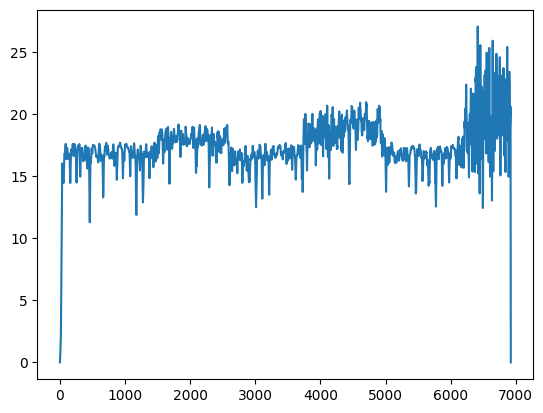

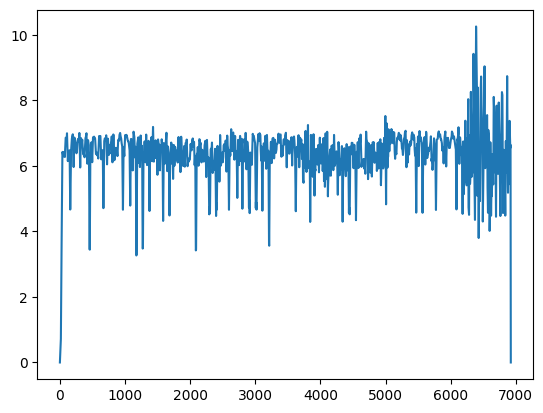

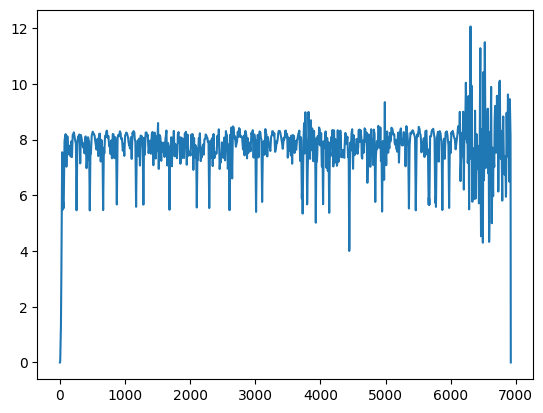

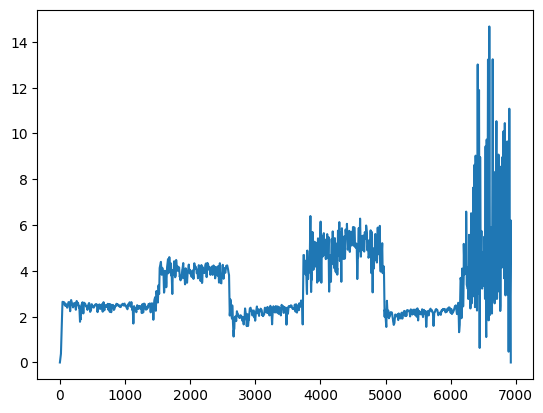

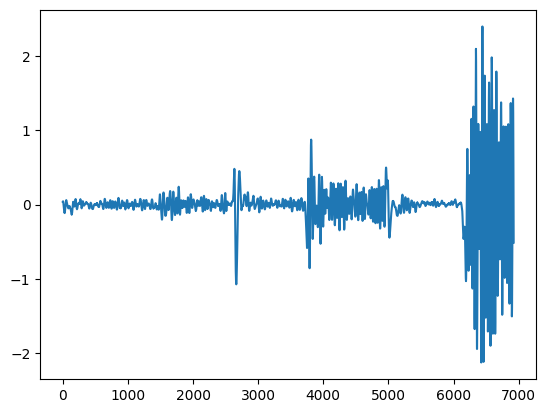

In [64]:
i=14

# in 6, combined pinch_data don't look good -> would this be a concern?
# in 14, would the last part be considered noise? should I be experimenting with filtering to get rid of it? -> filter frequyenct isnt optimized

plt.plot(pinch_data['f_Accel X'][i] + pinch_data['f_Accel Y'][i] + pinch_data['f_Accel Z'][i]) # shows what the phone is reading? but why would you do this when Android can already differentiate?
plt.show()
plt.plot(pinch_data['f_Accel X'][i])
plt.show()
plt.plot(pinch_data['f_Accel Y'][i])
plt.show()
plt.plot(pinch_data['f_Accel Z'][i]) # z is correlated? good signal to pick?
plt.show()

# plt.plot(pinch_data['f_Gyro X'][i])
plt.plot(pinch_data['Gyro X'][i])